In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [59]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import cumtrapz
from sklearn.mixture import GaussianMixture
import seaborn as sns
from true_params import true_params, uncert

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [23]:
with h5py.File('thetas.h5', 'r') as f:
    thetas = array(f['Theta'])
thetas = sort(concatenate((thetas, [0,1])))
ticum = interp1d(linspace(0, 1, len(thetas)), thetas)

with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    rhos = array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [26]:
oint.ev(array([1,2,3]), array([2,3,4]))

array([3.39704894, 5.34188423, 7.06473383])

In [39]:
def softening(x, x0, s):
    return exp(-0.5*square((log(x)-log(x0))/s))
def soft_pl_unnorm(x, a, x0, x1, s0, s1):
    pl = x**a
    
    sl = where(x < x0, softening(x, x0, s0), 1.0)
    sh = where(x > x1, softening(x, x1, s1), 1.0)
    
    return pl*sl*sh
def draw_soft_pl(N, a, x0, x1, s0, s1):
    xs = exp(linspace(log(x0)-5*s0, log(x1) + 5*s1, 1000))
    pls = soft_pl_unnorm(xs, a, x0, x1, s0, s1)
    cpls = cumtrapz(pls, xs, initial=0)
    icdf = interp1d(cpls, xs)
    
    return icdf(cpls[-1]*rand(N))
def draw_soft_pl_max(ys, a, x0, x1, s0, s1):
    xs = exp(linspace(log(x0)-5*s0, log(x1) + 5*s1, 1000))
    pls = soft_pl_unnorm(xs, a, x0, x1, s0, s1)
    cpls = cumtrapz(pls, xs, initial=0)
    cdf = interp1d(xs, cpls)
    icdf = interp1d(cpls, xs)
    
    cmaxs = cdf(ys)
    
    return icdf(cmaxs*rand(len(ys)))
def draw_z(R0, g, H0, Om, w, zmax):
    zs = expm1(linspace(log(1), log(1+zmax), 1000))
    c = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1.0-Om, w)
    dNdz = R0*4.0*pi*c.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**(g-1)
    N = trapz(dNdz, zs)
    zcum = cumtrapz(dNdz, zs, initial=0)
    
    icum = interp1d(zcum, zs)
    
    n = random.poisson(N)
    return icum(N*rand(n))
def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta
def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2
def draw(R0, MMin, MMax, alpha, beta, gamma, sl, sh, H0, Om, w):
    ztrue = draw_z(R0, gamma, H0, Om, w, 4)
    ctrue = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1-Om, w)
    dltrue = ctrue.luminosity_distance(ztrue).to(u.Gpc).value
    m1true = draw_soft_pl(len(ztrue), -alpha, MMin, MMax, sl, sh)
    m2true = draw_soft_pl_max(m1true, beta, MMin, MMax, sl, sh)
    m1trueobs = m1true*(1+ztrue)
    m2trueobs = m2true*(1+ztrue)
    thetatrue = ticum(rand(len(m1trueobs)))
    
    rhotrue = thetatrue*oint.ev(m1trueobs, m2trueobs)/dltrue
    
    rhoobs = rhotrue + randn(len(rhotrue))
    
    sel = rhoobs > 8
    
    ztrue = ztrue[sel]
    dltrue = dltrue[sel]
    m1true = m1true[sel]
    m2true = m2true[sel]
    m1trueobs = m1trueobs[sel]
    m2trueobs = m2trueobs[sel]
    rhotrue = rhotrue[sel]
    thetatrue = thetatrue[sel]
    rhoobs = rhoobs[sel]
    
    mctrueobs, etatrue = mc_eta_from_m1m2(m1trueobs, m2trueobs)
    
    smc = abs(uncert['threshold_snr']/rhoobs*uncert['mc'])
    mcobs = random.lognormal(mean=log(mctrueobs), sigma=smc)
    
    se = abs(uncert['threshold_snr']/rhoobs*uncert['eta'])
    etobs = etatrue + se*randn(len(se))
    while np.any(etobs > 0.25) or np.any(etobs < 0):
        s = (etobs > 0.25) | (etobs < 0)
        etobs[s] = etatrue[s] + se[s]*randn(len(se[s]))
    
    m1obs, m2obs = m1m2_from_mc_eta(mcobs, etobs)

    st = abs(uncert['threshold_snr']/rhoobs*uncert['Theta'])
    thetaobs = thetatrue + st*randn(len(st))
    while np.any(thetaobs < 0) or np.any(thetaobs > 1):
        s = (thetaobs < 0) | (thetaobs > 1)
        thetaobs[s] = thetatrue[s] + st[s]*randn(len(st[s]))
    
    dlobs = thetaobs*oint.ev(m1obs, m2obs)/rhoobs
    
    return m1obs, m2obs, dlobs, thetaobs

Number after 1 year = 923


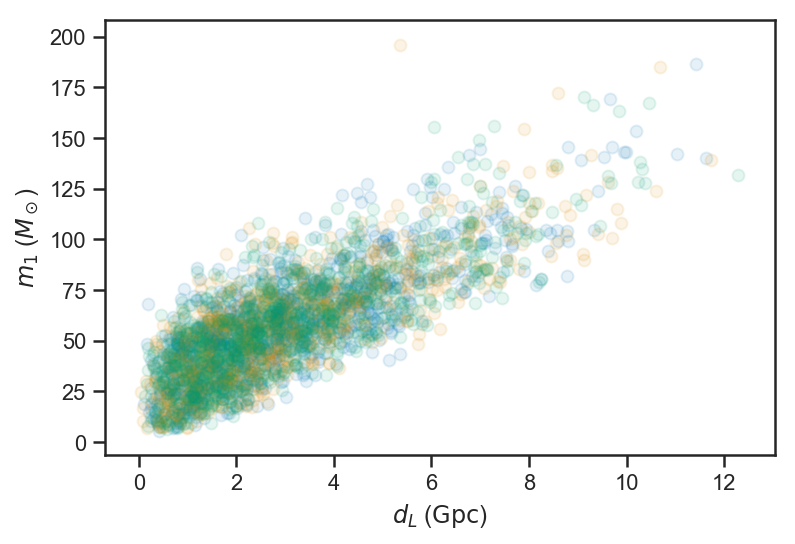

In [44]:
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
print('Number after 1 year = {:d}'.format(len(m1)))
scatter(dl, m1, alpha=0.1)
ylabel(r'$m_1$ ($M_\odot$)')
xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1.1)
scatter(dl, m1, alpha=0.1)
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -0.9)
scatter(dl, m1, alpha=0.1)

In [58]:
def compress(m1, dl):
    bins = sort(concatenate((percentile(dl, [10, 20, 30, 40, 50, 60, 70, 80, 90]), [0.0, np.max(dl)])))
    cent = 0.5*(bins[1:]+bins[:-1])
    
    ns, _ = np.histogram(dl, bins=bins)
    means, _ = np.histogram(dl, bins=bins, weights=m1)
    m2s, _ = np.histogram(dl, bins=bins, weights=m1*m1)
        
    means = means / ns
    vs = m2s/ns - means*means
    
    return len(m1), cent, means, sqrt(vs)

<ErrorbarContainer object of 3 artists>

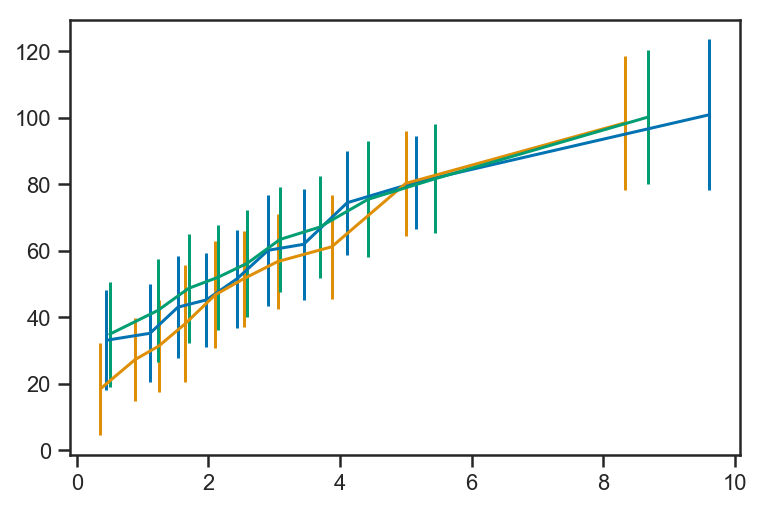

In [57]:
_, m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
c, m, s = compress(m1, dl)
errorbar(c, m, yerr=s)

_, m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 1.5, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
c, m, s = compress(m1, dl)
errorbar(c, m, yerr=s)

_, m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.25, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
c, m, s = compress(m1, dl)
errorbar(c, m, yerr=s)

In [61]:
p0_1yr = array([0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0])